Nz=501, Nh=500, dz=1.000e-03 m, dt=2.669e-12 s (CF=0.8)


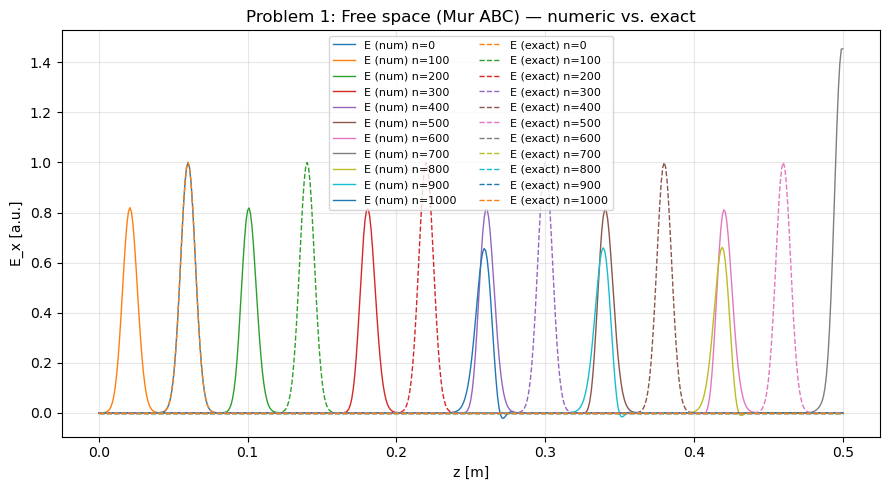

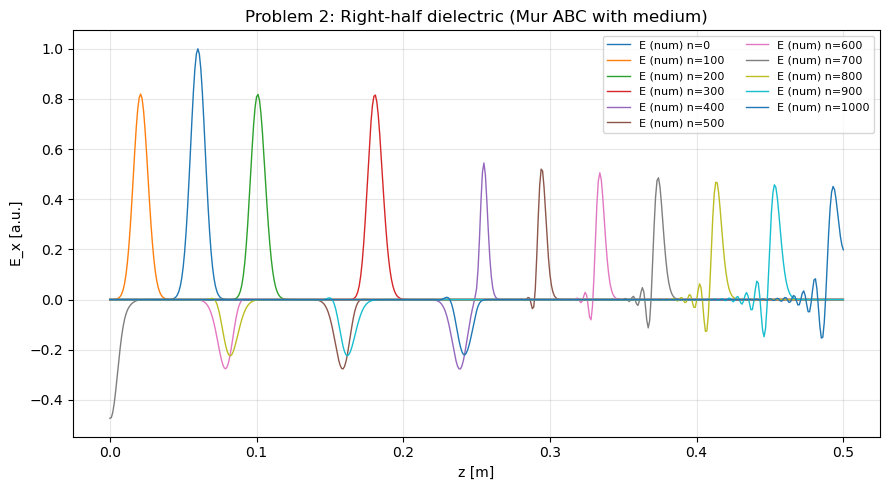

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 물리 상수 ----------
c0   = 299_792_458.0                 # [m/s]
mu0  = 4e-7 * np.pi                  # [H/m]
eps0 = 1.0 / (mu0 * c0**2)           # [F/m]
eta0 = np.sqrt(mu0 / eps0)           # ~ 376.73 ohm

# ---------- 격자/시간 설정 (PDF 조건) ----------
Lz   = 0.5                           # [m] domain length
dz   = 1e-3                          # [m] Δz (=> 501 nodes)
CF   = 0.8                           # Courant factor
dt   = CF * dz / c0                  # [s]
Nz   = int(Lz / dz) + 1              # E 노드 수 = 501
Nh   = Nz - 1                        # H 하프노드 수 = 500
z_e  = np.arange(Nz) * dz            # E 위치
z_h  = (np.arange(Nh) + 0.5) * dz    # H 위치 (하프셀)

# ---------- 초기조건 파라미터 (PDF) ----------
ic = 60   # 가우시안 중심 index (E)
iw = 7    # 가우시안 폭 (index 단위)

def init_fields_free():
    """자유공간 초기조건: E(z,0)=Gaussian, H(z,dt/2)=Gaussian/eta0 (stagger 보정)."""
    E = np.exp(-((np.arange(Nz) - ic) / iw)**2 )
    # H는 공간/시간 스태거 보정: i+1/2, n+1/2 => 중심과 CF/2 만큼 이동
    H = (1.0/eta0) * np.exp(-(((np.arange(Nh) + 0.5) - (ic + 0.5*CF)) / iw)**2 )
    return E.astype(np.float64), H.astype(np.float64)

def exact_free(i, n):
    """자유공간 정해: 우진행 가우시안 (index 기반)."""
    S = CF  # = c0*dt/dz
    return np.exp(-(((i - ic) - n*S) / iw)**2 )

# ---------- 업데이트 계수 ----------
def update_coeffs(eps_r_E):
    """매질 분포에 따른 계수 생성."""
    Ce = dt / (eps0 * eps_r_E * dz)  # E 업데이트 계수 (각 E노드별 eps_r)
    Ch = dt / (mu0 * dz)             # H는 비자성 가정 => 상수
    return Ce, Ch

# ---------- MUR 1차 ABC ----------
def mur_left(E_now, E_prev, S_left):
    """
    좌측 MUR: E[0]^{n+1} = E[1]^n + k*(E[1]^{n+1} - E[0]^n)
    k = (S-1)/(S+1), S = c*dt/(sqrt(eps_r)*dz) = CF / sqrt(eps_r_left)
    """
    k = (S_left - 1.0) / (S_left + 1.0)
    E_next0 = E_now[1] + k * (E_now[1] - E_prev[0])
    return E_next0

def mur_right(E_now, E_prev, S_right):
    """
    우측 MUR: E[N-1]^{n+1} = E[N-2]^n + k*(E[N-2]^{n+1} - E[N-1]^n)
    k = (S-1)/(S+1), S = c*dt/(sqrt(eps_r)*dz) = CF / sqrt(eps_r_right)
    """
    k = (S_right - 1.0) / (S_right + 1.0)
    E_nextN = E_now[-2] + k * (E_now[-2] - E_prev[-1])
    return E_nextN

# ---------- FDTD 루프 ----------
def run_fdtd(eps_r_E, n_steps=1000, snapshots=(0,100,200,300,400,500,600,700,800,900,1000),
             use_exact_free=True, title=''):
    """
    eps_r_E: 각 E노드의 상대유전율 배열 (길이 Nz)
    n_steps: 총 시간스텝
    snapshots: 저장할 스텝 인덱스 튜플
    use_exact_free: 자유공간 정해 플롯 여부
    """
    Ce, Ch = update_coeffs(eps_r_E)
    # 경계에서의 S = CF / sqrt(eps_r_edge)
    S_left  = CF / np.sqrt(eps_r_E[0])
    S_right = CF / np.sqrt(eps_r_E[-1])

    # 초기조건
    E, H = init_fields_free()
    E_prev = E.copy()

    # 결과 저장
    Es = {}        # step -> E 복사본
    Exacts = {}    # step -> 정해

    # 스냅샷 0 저장
    if 0 in snapshots:
        Es[0] = E.copy()
        if use_exact_free:
            Exacts[0] = exact_free(np.arange(Nz), 0)

    # 시간 전개
    for n in range(1, n_steps+1):
        # --- H 업데이트: i=0..Nh-1  (Hy^{n+1/2})
        # H[i] += Ch * (E[i+1] - E[i])
        H += Ch * (E[1:] - E[:-1])

        # --- E 내부 업데이트: i=1..Nz-2
        En = E.copy()  # n시점 보관 (MUR 필요)
        E[1:-1] += Ce[1:-1] * (H[1:] - H[:-1])

        # --- MUR ABC (좌/우 경계) ---
        E[0]  = mur_left(E, En, S_left)
        E[-1] = mur_right(E, En, S_right)

        # --- 스냅샷 저장 ---
        if n in snapshots:
            Es[n] = E.copy()
            if use_exact_free:
                Exacts[n] = exact_free(np.arange(Nz), n)

        E_prev = En  # 다음 스텝을 위해 저장

    # 플롯
    plt.figure(figsize=(9,5))
    for n, arr in Es.items():
        plt.plot(z_e, arr, lw=1.0, label=f'E (num) n={n}')
    if use_exact_free and len(Exacts)>0:
        # 정해는 눈에 띄도록 얇은 점선
        for n, arr in Exacts.items():
            plt.plot(z_e, arr, linestyle='--', linewidth=1.0, label=f'E (exact) n={n}')
    plt.xlabel('z [m]')
    plt.ylabel('E_x [a.u.]')
    plt.title(title if title else '1D FDTD with Mur ABC')
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

    return Es, Exacts

# ---------- 실행: Problem 1 (자유공간) ----------
if __name__ == '__main__':
    print(f'Nz={Nz}, Nh={Nh}, dz={dz:.3e} m, dt={dt:.3e} s (CF={CF})')

    # Problem 1: Free space (eps_r=1 everywhere), 정해와 비교
    eps_r_free = np.ones(Nz, dtype=np.float64)
    run_fdtd(eps_r_free,
             n_steps=1000,
             snapshots=tuple(range(0,1001,100)),
             use_exact_free=True,
             title='Problem 1: Free space (Mur ABC) — numeric vs. exact')

    # Problem 2: 우측 반공간 유전체 (예: eps_r=4.0) — 우측 MUR에 매질 반영
    eps_r_diel = np.ones(Nz, dtype=np.float64)
    z0, z1 = 0.25, 0.5   # [m] dielectric region
    i0, i1 = int(z0/dz), int(z1/dz)
    eps_r_diel[i0:i1+1] = 4.0  # 필요시 과제값으로 수정

    # 정해 비교는 생략(계면 반사/투과 포함한 해석해는 별도 유도 필요)
    run_fdtd(eps_r_diel,
             n_steps=1000,
             snapshots=tuple(range(0,1001,100)),
             use_exact_free=False,
             title='Problem 2: Right-half dielectric (Mur ABC with medium)')

In [10]:
# fdtd_1d_mur_singlewave_anim.py
# ✅ 단일 +z 진행파 유지 / ✅ MUR 경계 정확화 / ✅ HTML & MP4 애니 저장

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, writers

# --- 물리 상수 ---
c0   = 299_792_458.0
mu0  = 4e-7 * np.pi
eps0 = 1.0 / (mu0 * c0**2)
eta0 = np.sqrt(mu0 / eps0)

# --- 격자/시간 (문제 조건) ---
Lz = 0.5
dz = 1e-3
CF = 0.8
dt = CF * dz / c0
Nz = int(Lz/dz) + 1      # 501
Nh = Nz - 1              # 500
zE = np.arange(Nz) * dz
zH = (np.arange(Nh) + 0.5) * dz

# --- 가우시안 (index 기반) ---
ic, iw = 60, 7
def g_idx(x):  # x: index 공간
    return np.exp(-((x - ic)/iw)**2)

# --- 단일 +z 진행 초기조건 (스태거 반영) ---
def init_single_rightgoing():
    # E at t=0
    E = g_idx(np.arange(Nz)).astype(np.float64)
    # H at t=+dt/2 (half-step, half-cell shift): g(i+1/2 - S/2)
    S = CF
    H = (1.0/eta0) * g_idx((np.arange(Nh)+0.5) - 0.5*S)
    return E, H.astype(np.float64)

# --- MUR(1차) 경계: 반드시 En(이전시각) 참조 ---
def mur_left(E_now, En, S_left):
    k = (S_left - 1.0) / (S_left + 1.0)
    # E0^{n+1} = E1^{n} + k*(E1^{n+1} - E0^{n})
    return En[1] + k * (E_now[1] - En[0])

def mur_right(E_now, En, S_right):
    k = (S_right - 1.0) / (S_right + 1.0)
    # EN^{n+1} = EN-1^{n} + k*(EN-1^{n+1} - EN^{n})
    return En[-2] + k * (E_now[-2] - En[-1])

# --- FDTD 루프 (부호·스텐실 정확) ---
def run_fdtd_frames(eps_r_E, frames_to_capture, with_exact=False):
    Ce = dt / (eps0 * eps_r_E * dz)
    Ch = dt / (mu0 * dz)
    S_left  = CF / np.sqrt(eps_r_E[0])
    S_right = CF / np.sqrt(eps_r_E[-1])

    E, H = init_single_rightgoing()

    frames_E = []
    frames_exact = []

    if 0 in frames_to_capture:
        frames_E.append(E.copy())
        if with_exact:
            S = CF
            frames_exact.append(g_idx(np.arange(Nz) - 0.0*S))

    n_end = max(frames_to_capture)
    for n in range(1, n_end+1):
        En = E.copy()

        # H^{n+1/2} = H^{n-1/2} - (dt/(μ dz)) (E^n_{i+1} - E^n_i)
        H += -Ch * (En[1:] - En[:-1])

        # E^{n+1}_i = E^n_i - (dt/(ε dz)) (H^{n+1/2}_{i+1/2} - H^{n+1/2}_{i-1/2})
        E[1:-1] = En[1:-1] - Ce[1:-1] * (H[1:] - H[:-1])

        # 경계 (MUR, 매질 의존)
        E[0]  = mur_left(E, En, S_left)
        E[-1] = mur_right(E, En, S_right)

        if n in frames_to_capture:
            frames_E.append(E.copy())
            if with_exact:
                S = CF
                frames_exact.append(g_idx(np.arange(Nz) - n*S))

    return np.array(frames_E), (np.array(frames_exact) if with_exact else None)

# --- 공통: 프레임 목록 (문제 요구) ---
frames_list = list(range(0, 1001, 100))  # 0,100,...,1000 (11프레임)

# --- 문제 1: 자유공간 ---
eps_free = np.ones(Nz)
E_num_1, E_ex_1 = run_fdtd_frames(eps_free, frames_list, with_exact=True)

# --- 문제 2: 우측 유전체 (z ∈ [0.25, 0.5]) ---
eps_diel = np.ones(Nz)
i0, i1 = int(0.25/dz), int(0.5/dz)
eps_diel[i0:i1+1] = 4.0
E_num_2, _ = run_fdtd_frames(eps_diel, frames_list, with_exact=False)

# ========= 애니메이션 저장 (HTML & MP4) =========

def save_anim_numeric_vs_exact(z, frames_num, frames_ex, frames_ticks, title, html_path, mp4_path=None):
    fig, ax = plt.subplots(figsize=(8, 4.5))
    (ln_num,) = ax.plot(z, frames_num[0], lw=1.8, label="E (numeric)")
    (ln_ex,)  = ax.plot(z, frames_ex[0],  '--', lw=1.2, label="E (exact)")
    ax.set_xlim(z[0], z[-1])
    ymin = min(frames_num.min(), frames_ex.min())
    ymax = max(frames_num.max(), frames_ex.max())
    ax.set_ylim(ymin*1.1, ymax*1.1)
    ax.grid(True, alpha=0.3); ax.legend(loc="upper right", fontsize=9)
    ax.set_xlabel("z [m]"); ax.set_ylabel("E_x [a.u.]")
    ax.set_title(f"{title} — n = {frames_ticks[0]}")

    def upd(i):
        ln_num.set_ydata(frames_num[i])
        ln_ex.set_ydata(frames_ex[i])
        ax.set_title(f"{title} — n = {frames_ticks[i]}")
        return (ln_num, ln_ex)

    anim = FuncAnimation(fig, upd, frames=len(frames_ticks), interval=350, blit=True)
    # HTML
    with open(html_path, "w", encoding="utf-8") as f:
        f.write(anim.to_jshtml())
    # MP4 (옵션)
    if mp4_path:
        if writers.is_available('ffmpeg'):
            anim.save(mp4_path, writer=FFMpegWriter(fps=2, bitrate=1800), dpi=150)
        else:
            print("⚠️ ffmpeg 미설치: MP4 저장 생략")
    plt.close(fig)

def save_anim_numeric_only(z, frames_num, frames_ticks, title, html_path, mp4_path=None, marks=None):
    fig, ax = plt.subplots(figsize=(8, 4.5))
    (ln_num,) = ax.plot(z, frames_num[0], lw=1.8, label="E (numeric)")
    if marks:
        for x in marks:
            ax.axvline(x, linestyle=":", lw=1.0)
    ax.set_xlim(z[0], z[-1])
    ymin = frames_num.min(); ymax = frames_num.max()
    ax.set_ylim(ymin*1.1, ymax*1.1)
    ax.grid(True, alpha=0.3); ax.legend(loc="upper right", fontsize=9)
    ax.set_xlabel("z [m]"); ax.set_ylabel("E_x [a.u.]")
    ax.set_title(f"{title} — n = {frames_ticks[0]}")

    def upd(i):
        ln_num.set_ydata(frames_num[i])
        ax.set_title(f"{title} — n = {frames_ticks[i]}")
        return (ln_num,)

    anim = FuncAnimation(fig, upd, frames=len(frames_ticks), interval=350, blit=True)
    with open(html_path, "w", encoding="utf-8") as f:
        f.write(anim.to_jshtml())
    if mp4_path:
        if writers.is_available('ffmpeg'):
            anim.save(mp4_path, writer=FFMpegWriter(fps=2, bitrate=1800), dpi=150)
        else:
            print("⚠️ ffmpeg 미설치: MP4 저장 생략")
    plt.close(fig)

# 저장 경로
html1 = "FDTD_Problem1_free_space_11frames.html"
mp41  = "FDTD_Problem1_free_space_11frames.mp4"
html2 = "FDTD_Problem2_dielectric_11frames.html"
mp42  = "FDTD_Problem2_dielectric_11frames.mp4"

# 문제 1: 수치 vs 정해
save_anim_numeric_vs_exact(
    zE, E_num_1, E_ex_1, frames_list,
    "Problem 1: Free space (MUR)",
    html1, mp41
)

# 문제 2: 수치만 (유전체 영역 표시)
save_anim_numeric_only(
    zE, E_num_2, frames_list,
    "Problem 2: Dielectric (MUR, medium-aware)",
    html2, mp42,
    marks=[zE[i0], zE[i1]]
)

print("Saved:", html1, mp41, html2, mp42)


Saved: FDTD_Problem1_free_space_11frames.html FDTD_Problem1_free_space_11frames.mp4 FDTD_Problem2_dielectric_11frames.html FDTD_Problem2_dielectric_11frames.mp4
